# Data wrangling Project - We Rate Dogs (Twitter Data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import json
import datetime
from bs4 import BeautifulSoup
import os
import io
import glob
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
from scipy import stats 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

## 1- Data Gathering 

### 1-1- file in hand 'Twitter-archive-enhanced.csv'

In [2]:
# reading .csv file downloaded manually.
df_1 = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df_1.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None



### 1-2-File download programmatically 


In [4]:

folder_name = 'File_from_the_internet'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)

In [5]:
with open(os.path.join(folder_name,url.split('/')[-1]),mode='wb') as file :
    file.write(response.content)
    os.listdir(folder_name)
    

In [6]:
df_2 = pd.read_csv('image-predictions.tsv', sep = '\t')


In [7]:
df_2.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

### 1-3- File from Twitter API

consumer_key = '****'
consumer_secret = '********'
access_token = '********'
access_secret = '********'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

exp_tweet = api.get_status(df_1.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
content

#Creating a file for the tweets' text data


errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in df_1['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

In [8]:
df_list = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        print(type(line))
        tweet = json.loads(line)
        print(type(tweet))
        break

<class 'str'>
<class 'dict'>


In [9]:
df_list = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df_now = pd.DataFrame(df_list)
api_df_now.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7431,35237
1,892177421306343426,5526,30502
2,891815181378084864,3647,22937
3,891689557279858688,7608,38519
4,891327558926688256,8192,36792


In [10]:
df_list = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})
        
df_3_api = pd.DataFrame(df_list)
df_3_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   retweet_count   2326 non-null   int64
 2   favorite_count  2326 non-null   int64
 3   user_count      2326 non-null   int64
dtypes: int64(4)
memory usage: 72.8 KB


## 2- Data Assessing 

### 2-1- Quality issues 

#### 2-1-1- df_1 

In [11]:
df_1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [12]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

##### 1- Completeness  :
- We need to remove replies
- retweets and reply to users also need to be deleted.
- ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp' ] are columns to drop

- column 'expanded_urls' has 59 Nan values we can drop

##### 2- Validity :
- 'tweet_id' must be string.
- 'denomerator'' column has some values != 10 which doesn't make sense either.

##### 3- accuracy :
- Nothing here.

##### 4- Consistency :
- We need to check for some odd tweets based on inacurate rating values.
- timestamp column has +0000 in it

#### 2-1-2- df_2

In [13]:
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [14]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


##### 1- Mising Data columns  :
- 	No missing data

##### 2- not valid data :
- Nothing to do
##### 3- accuerecy :
- we shall just take some info from this DF so we can handle the merging process later.

##### 4- Consistency :
- nothing to do.

#### 2-1-3- df_3

In [15]:
df_3_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   retweet_count   2326 non-null   int64
 2   favorite_count  2326 non-null   int64
 3   user_count      2326 non-null   int64
dtypes: int64(4)
memory usage: 72.8 KB


##### 1- Completeness   :
- Nothing

##### 2- Validity :
- 'tweet_id' must be a string.

##### 3- Accuerecy :
- nothing.

##### 4- Consistency :
- nothing.

### 2-2- Tidiness issues 

#### 2-2-1- df_1

In [16]:
df_1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


#####  Each variable forms a column and contains values
- Dogs types are columns.

##### Each observation forms a row
- nothing

#####  Each type of observational unit forms a table
- nothing

#### 2-2-2- df_2

In [17]:
df_2.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


##### Each variable forms a column and contains values
- Dogs dtection are columns.

##### Each observation forms a row
- 'tweet_id' must be string.

##### Each type of observational unit forms a table
- nothing

#### 2-2-3- df_3

In [18]:
df_3_api.head()

,tweet_id,retweet_count,favorite_count,user_count
0,892420643555336193,7431,35237,8946069
1,892177421306343426,5526,30502,8946069
2,891815181378084864,3647,22937,8946069
3,891689557279858688,7608,38519,8946069
4,891327558926688256,8192,36792,8946069


##### Each variable forms a column and contains values
- nothing wrong here.

##### Each observation forms a row
- nothing wrong here.

##### Each type of observational unit forms a table
- nothing wrong here.

## 3- Data Cleaning 

### 3-1 Fixing Quality Issues 

#### 3-1-1- df_1

In [19]:
# making a copy fromthe dataframe :
df_1_clean = df_1.copy()
df_1_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### A- Define :

* We need to remove replies.

##### B- Code :
    

In [20]:
#drop :
df_1_clean = df_1_clean[df_1_clean['in_reply_to_status_id'].isnull()]

#### C-Test:

In [21]:
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2278 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2278 non-null   object 
 4   source                      2278 non-null   object 
 5   text                        2278 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2274 non-null   object 
 10  rating_numerator            2278 non-null   int64  
 11  rating_denominator          2278 non-null   int64  
 12  name                        2278 non-null   object 
 13  doggo                       2278 

##### A- Define :

* We need to remove retweets. using filter by an drop()

##### B- Code :
    

In [22]:
#drop :
df_1_clean = df_1_clean[df_1_clean['retweeted_status_id'].isnull()]

#### C-Test:

In [23]:
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

##### A- Define :
* column 'expanded_urls' has 59 Nan values we can drop

##### B- Code :
    

In [24]:
df_1_clean.dropna(subset = ['expanded_urls'], inplace = True)

#### C-Test:

In [25]:
df_1_clean.expanded_urls.isnull().sum()

0

##### A- Define :

* Columns ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'] will be deleted using.drop()

##### B- Code :
    

In [26]:
# dropping columns using a for loop and a series :
columns_to_drop = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','source','expanded_urls']
df_1_clean.drop(columns = columns_to_drop, inplace = True)

#### C-Test:

In [27]:
df_1_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


##### 2- not valid data :


##### A- Define :

* 'denomerator'' column has some values != 10 which doesn't make sense either.

##### B- Code :
    

In [28]:
# Calculating the dogs counts in the tweets featuring many dogs
dog_count = df_1_clean.rating_denominator[df_1_clean['rating_numerator'] >= 40 ]/10

df_1_clean.loc[df_1_clean.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [df_1_clean.rating_numerator[df_1_clean.rating_numerator >= 40]/dog_count , 10]


#### C-Test:

In [29]:
df_1_clean[df_1_clean['rating_denominator']>= 40].sum()

tweet_id              0.0
timestamp             0.0
text                  0.0
rating_numerator      0.0
rating_denominator    0.0
name                  0.0
doggo                 0.0
floofer               0.0
pupper                0.0
puppo                 0.0
dtype: float64

##### A- Define :
* 'tweet_id' must be a string using astybe()


##### B- Code :

In [30]:
df_1_clean['tweet_id'] = df_1_clean['tweet_id'].astype('string')

#### C-Test:

In [31]:
df_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2094 non-null   string 
 1   timestamp           2094 non-null   object 
 2   text                2094 non-null   object 
 3   rating_numerator    2094 non-null   float64
 4   rating_denominator  2094 non-null   int64  
 5   name                2094 non-null   object 
 6   doggo               2094 non-null   object 
 7   floofer             2094 non-null   object 
 8   pupper              2094 non-null   object 
 9   puppo               2094 non-null   object 
dtypes: float64(1), int64(1), object(7), string(1)
memory usage: 180.0+ KB


##### A- Define :
* 'denomerator'' column has some values != 10 which doesn't make sense either,we should devide by number of dog in each tweet using deision.

##### B- Code :
    

In [32]:
df_1_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,None,None,None,None


In [33]:
df_1_clean.query('rating_denominator > 20 ')

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### C-Test:

##### 3- accuerecy :

##### A- Define :
* timestamp column has a +0000 in the last degits,we need to clear that using .spilt()[:-5]

##### B- Code :
    

In [34]:
df_1_clean['timestamp']= df_1_clean['timestamp'].astype(str).str[:-5]


##### C-Test:

In [35]:
df_1_clean['timestamp']

0       2017-08-01 16:23:56 
1       2017-08-01 00:17:27 
2       2017-07-31 00:18:03 
3       2017-07-30 15:58:51 
4       2017-07-29 16:00:24 
                ...         
2351    2015-11-16 00:24:50 
2352    2015-11-16 00:04:52 
2353    2015-11-15 23:21:54 
2354    2015-11-15 23:05:30 
2355    2015-11-15 22:32:08 
Name: timestamp, Length: 2094, dtype: object

##### 4- Consistency :

##### Aditional Cleaning :

* We need to check for some odd tweets based on inacurate rating values. and delete them. using drop()

_______________________________________________________________________________________________________________________________

#### 3-1-2- df_2

In [36]:
#copy :
df_2_clean = df_2.copy()
df_2_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


##### A- Define :

- 'tweet_id' must be string

##### B- Code :
    

In [37]:
df_2_clean['tweet_id'] = df_2_clean['tweet_id'].astype('string')

##### C-Test:

In [38]:
df_2_clean['tweet_id']

0       666020888022790149
1       666029285002620928
2       666033412701032449
3       666044226329800704
4       666049248165822465
               ...        
2070    891327558926688256
2071    891689557279858688
2072    891815181378084864
2073    892177421306343426
2074    892420643555336193
Name: tweet_id, Length: 2075, dtype: string

#### 3-1-3- df_3

In [39]:
#copy :
df_3_clean = df_3_api.copy()
df_3_clean

,tweet_id,retweet_count,favorite_count,user_count
0,892420643555336193,7431,35237,8946069
1,892177421306343426,5526,30502,8946069
2,891815181378084864,3647,22937,8946069
3,891689557279858688,7608,38519,8946069
4,891327558926688256,8192,36792,8946069
...,...,...,...,...
2321,666049248165822465,39,94,8946189
2322,666044226329800704,123,262,8946189
2323,666033412701032449,39,107,8946189
2324,666029285002620928,41,118,8946189


##### A- Define :

- 'tweet_id' must be string

##### B- Code :
    

In [40]:
df_3_clean['tweet_id'] = df_3_clean['tweet_id'].astype('string')

##### C-Test:

In [41]:
df_3_clean['tweet_id']

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2321    666049248165822465
2322    666044226329800704
2323    666033412701032449
2324    666029285002620928
2325    666020888022790149
Name: tweet_id, Length: 2326, dtype: string

### 3-2-  Fixing Tidiness Issues 

#### 3-2-1- df_1

##### A- Define :

- Dogs dtection are columns.

##### B- Code :
    

In [42]:
df_1_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,None,None,None,None


##### B- Code :
    

In [43]:
df_1_clean = pd.melt(df_1_clean, id_vars=['tweet_id',
                                          'timestamp',
                                          'text',
                                          'rating_numerator',
                                          'rating_denominator',
                                          'name'],var_name='dogs', value_name='dogs_breed')

df_1_clean = df_1_clean.drop('dogs',1)
df_1_clean = df_1_clean.sort_values ('dogs_breed').drop_duplicates(subset='tweet_id',keep="last")

##### C-Test:

In [44]:
df_1_clean['dogs_breed'].value_counts()

None       1759
pupper      229
doggo        72
puppo        24
floofer      10
Name: dogs_breed, dtype: int64

#### 3-2-2- df_2

##### A- Define :

- Renaming columns

##### B- Code :

In [45]:
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
df_2_clean.columns = cols

# Reshaping the dataframe
test = pd.wide_to_long(df_2_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

##### C-Test:

In [46]:
df_2_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### A- Define :

- Reshape dataframe to br tidy.

In [47]:
df_2_clean.columns


Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_1', 'confidence_1',
       'breed_1', 'prediction_2', 'confidence_2', 'breed_2', 'prediction_3',
       'confidence_3', 'breed_3'],
      dtype='object')

##### B- Code :

In [48]:
df_2_clean = df_2_clean.reset_index()

In [49]:
df_2_clean = pd.wide_to_long(df_2_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()


##### C-Test:

In [50]:
df_2_clean.head()

,tweet_id,jpg_url,img_num,prediction_level,index,prediction,confidence,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,0,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,0,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,0,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,1,miniature_pinscher,0.074192,True


In [51]:
#dropping the index column:

df_2_clean = df_2_clean.drop(columns ='index', axis = 1)

In [52]:
df_2_clean.head(1)

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True


#### 3-2-3- df_3

- Nothing to do, we already fixed the id datatype.

### 3-3 Combine Data Frames

##### A- Define :

- Commpine DF_1 & DF_3 and replace Nans' 

##### B- Code :

In [53]:
df_master = df_1_clean.merge(df_3_clean, how= 'inner' )


##### C-Test:

In [54]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2081
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2082 non-null   string 
 1   timestamp           2082 non-null   object 
 2   text                2082 non-null   object 
 3   rating_numerator    2082 non-null   float64
 4   rating_denominator  2082 non-null   int64  
 5   name                2082 non-null   object 
 6   dogs_breed         2082 non-null   object 
 7   retweet_count       2082 non-null   int64  
 8   favorite_count      2082 non-null   int64  
 9   user_count          2082 non-null   int64  
dtypes: float64(1), int64(4), object(4), string(1)
memory usage: 178.9+ KB


##### A- Define :

- dropping Nan values from master data frame :

##### B- Code :

In [55]:
df_master.loc[df_master.dogs_breed == "None", 'dogs_breed'] = np.nan


##### C-Test:

In [56]:

df_master.isnull().sum()

tweet_id                 0
timestamp                0
text                     0
rating_numerator         0
rating_denominator       0
name                     0
dogs_breed           1750
retweet_count            0
favorite_count           0
user_count               0
dtype: int64

_______________________________________________________________________________________________________________________________

## 4- Data Storing  

In [57]:
df_master.to_csv('Master_DataFrame.csv')

In [58]:
df_2_clean.to_csv('Image_prediction.csv')

## 5- Data Visualization 

### 5-1 Dogs Rating Insights :

#### 5-1-1 Dogs rating Based on their breed :

In [59]:
#Rating mean for each breed:
mean = df_master.groupby('dogs_breed').rating_numerator.mean()
mean

dogs_breed
doggo      11.830986
floofer    11.800000
pupper     10.814978
puppo      12.041667
Name: rating_numerator, dtype: float64

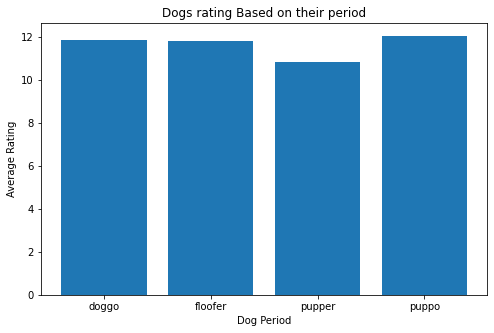

In [60]:
plt.subplots(figsize=(8, 5))
plt.bar(mean.index,mean)
plt.title('Dogs rating Based on their breed')
plt.xlabel('Dog breed')
plt.ylabel('Average Rating');
plt.savefig('Dogs rating Based on their breed')

#### 5-1-2 Dogs total interaction Based on their breed :

In [61]:
df_master.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dogs_breed,retweet_count,favorite_count,user_count
0,667435689202614272,2015-11-19 20:14:03,Ermergerd 12/10 https://t.co/PQni2sjPsm,12.0,10,None,NaN,79,286,8946190


In [62]:
#Rating mean for each breed:
df_master['total_interaction'] = df_master['retweet_count']+df_master['favorite_count']
mean_1 = df_master.groupby('dogs_breed').total_interaction.mean()
mean_1

dogs_breed
doggo      22895.507042
floofer    13845.700000
pupper      9022.013216
puppo      27520.208333
Name: total_interaction, dtype: float64

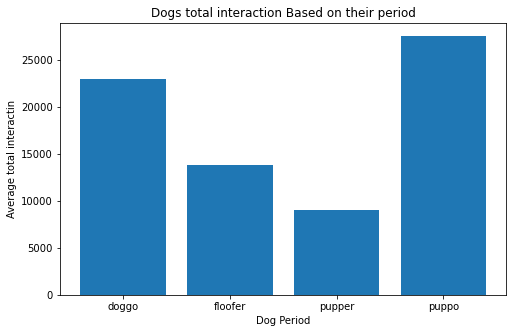

In [63]:
plt.subplots(figsize=(8, 5))
plt.bar(mean_1.index,mean_1)
plt.title('Dogs total interaction Based on their breed')
plt.xlabel('Dog breed')
plt.ylabel('Average total interactin');
plt.savefig('Dogs total interaction Based on their breed')

#### 5-1-3 Dogs total ownership :

In [64]:
mean_2 = df_2_clean.prediction.value_counts().nlargest(10)
mean_2

golden_retriever      290
Labrador_retriever    283
Chihuahua             185
Pembroke              143
Cardigan              115
Pomeranian            109
toy_poodle            105
pug                    97
chow                   96
cocker_spaniel         95
Name: prediction, dtype: int64

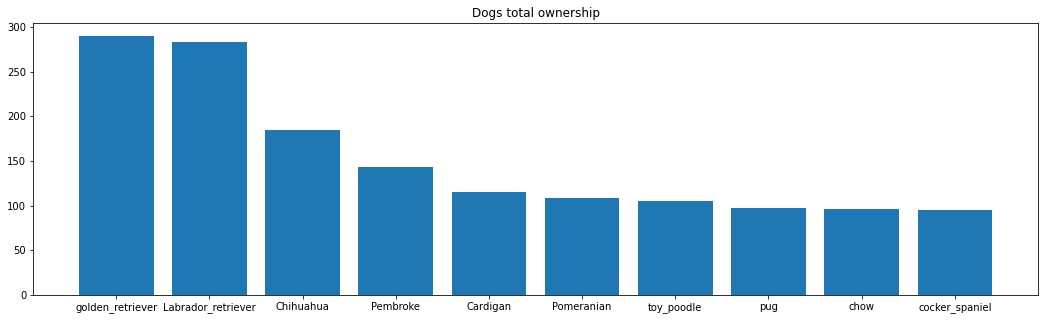

In [65]:
plt.subplots(figsize=(18, 5))
plt.bar(mean_2.index,mean_2)
plt.title('Dogs total ownership')
plt.savefig('Dogs total ownership')

### 5-2 Account Insights :

#### 5-2-1 Total interaction over the 3 years :

In [66]:
df_t = df_master.copy()

In [67]:
df_t['timestamp'] = pd.to_datetime(df_t.timestamp)

In [68]:
df_t.index = df_t['timestamp']

In [69]:
df_t.drop(columns='timestamp',  inplace=True)

In [70]:
df_t.sort_index(inplace=True)

In [71]:
data_to_plot = df_t.groupby([(df_t.index.year),(df_t.index.month)]).total_interaction.mean()


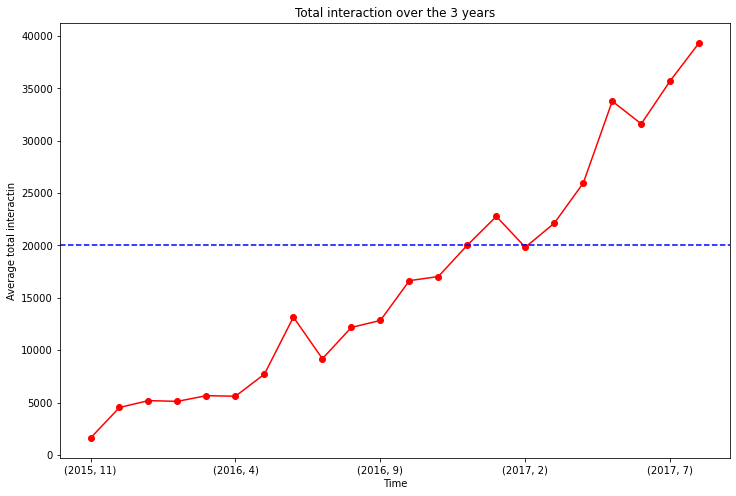

In [72]:
data_to_plot.plot(style='-ro', figsize=(12,8),label='Total average interaction')

plt.title('Total interaction over the 3 years')
plt.xlabel('Time')
plt.ylabel('Average total interactin');

plt.axhline(y=20000, color='b', linestyle='--', label='Out of rating')
plt.savefig('Total interaction over the 3 years')

#### 5-2-2 Total Tweet numbers over the 3 years :

In [73]:
data_to_plot_1 = df_t.groupby([(df_t.index.year),(df_t.index.month)]).tweet_id.count()

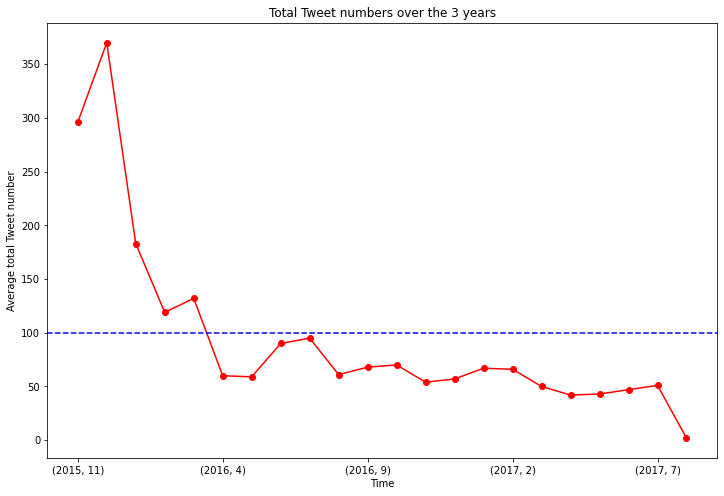

In [74]:
data_to_plot_1.plot(style='-ro', figsize=(12,8),label='Total average Tweet number')

plt.title('Total Tweet numbers over the 3 years')
plt.xlabel('Time')
plt.ylabel('Average total Tweet number');

plt.axhline(y=100, color='b', linestyle='--', label='Out of rating')
plt.savefig('Total Tweet numbers over the 3 years')